Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# AutoML with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we use a binary classification task to showcase the task-oriented AutoML in FLAML library.

FLAML requires `Python>=3.7`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
%pip install flaml[notebook]==1.1.1

## 2. Classification Example
### Load data and preprocess

Download [Airlines dataset](https://www.openml.org/d/1169) from OpenML. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure.

In [2]:
from flaml.data import load_openml_dataset

X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=1169, data_dir='./')

download dataset from openml
Dataset name: airlines
X_train.shape: (404537, 7), y_train.shape: (404537,);
X_test.shape: (134846, 7), y_test.shape: (134846,)


In [ ]:
X_train.head()

### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default classifiers are `['lgbm', 'xgboost', 'xgb_limitdepth', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [3]:
''' import AutoML class from flaml package '''
from flaml import AutoML

automl = AutoML()

In [4]:
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'accuracy', 
                        # check the documentation for options of metrics (https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#optimization-metric)
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment.log',  # flaml log file
    "seed": 7654321,    # random seed
}


In [5]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl.automl: 01-09 03:09:59] {2625} INFO - task = classification
[flaml.automl.automl: 01-09 03:09:59] {2627} INFO - Data split method: stratified
[flaml.automl.automl: 01-09 03:09:59] {2630} INFO - Evaluation method: holdout
[flaml.automl.automl: 01-09 03:09:59] {2757} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.automl: 01-09 03:09:59] {2902} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.automl: 01-09 03:09:59] {3203} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 01-09 03:09:59] {3340} INFO - Estimated sufficient time budget=10919s. Estimated necessary time budget=268s.
[flaml.automl.automl: 01-09 03:09:59] {3387} INFO -  at 0.5s,	estimator lgbm's best error=0.3777,	best estimator lgbm's best error=0.3777
[flaml.automl.automl: 01-09 03:09:59] {3203} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 01-09 03:09:59] {3387} INFO -  at 0.5s,	estimator

### Best model and metric

In [6]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 302, 'num_leaves': 466, 'min_child_samples': 128, 'learning_rate': 0.08749366799403727, 'log_max_bin': 7, 'colsample_bytree': 0.763983850698587, 'reg_alpha': 0.09968008477303378, 'reg_lambda': 23.22741934331899, 'FLAML_sample_size': 364083}
Best accuracy on validation data: 0.675
Training duration of best run: 9.817 s


In [7]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.763983850698587,
               learning_rate=0.08749366799403727, max_bin=127,
               min_child_samples=128, n_estimators=302, num_leaves=466,
               reg_alpha=0.09968008477303378, reg_lambda=23.22741934331899,
               verbose=-1)

In [8]:
'''pickle and save the automl object'''
import pickle

with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [9]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels ['1' '0' '1' ... '1' '0' '0']
True labels 118331    0
328182    0
335454    0
520591    1
344651    0
         ..
367080    0
203510    1
254894    0
296512    1
362444    0
Name: Delay, Length: 134846, dtype: category
Categories (2, object): ['0' < '1']


In [10]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score

print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))

accuracy = 0.6732939797991784
roc_auc = 0.7276250346550404
log_loss = 0.6014655432027879


See Section 4 for an accuracy comparison with default LightGBM and XGBoost.

### Log history

In [11]:
from flaml.data import get_output_from_log

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}}
{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 26, 'num_leaves': 4, 'min_child_samples': 18, 'learning_rate': 0.2293009676418639, 'log_max_bin': 9, 'colsample_bytree': 0.9086551727646448, 'reg_alpha': 0.0015561782752413472, 'reg_lambda': 0.33127416269768944, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 26, 'num_leaves': 4, 'min_chi

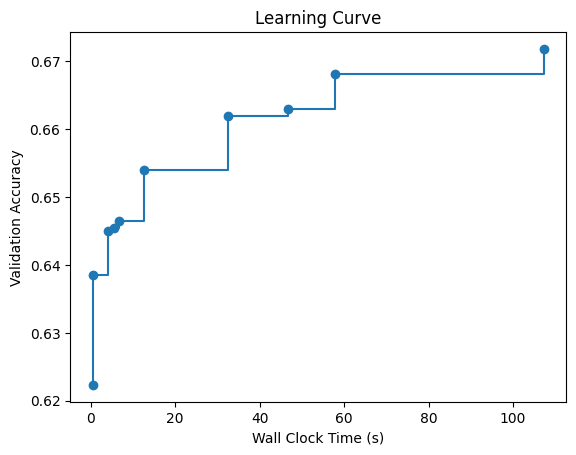

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Comparison with alternatives


### Default LightGBM

In [13]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()

In [14]:
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [15]:
y_pred_lgbm = lgbm.predict(X_test)

### Default XGBoost

In [23]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
cat_columns = X_train.select_dtypes(include=['category']).columns
X = X_train.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
y_train = y_train.astype('int')
y_test_xgb = y_test.astype('int')

In [24]:
xgb.fit(X, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [25]:
X = X_test.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
y_pred_xgb = xgb.predict(X)

In [26]:
print('default xgboost accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_xgb, y_test_xgb))
print('default lgbm accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_lgbm, y_test))
print('flaml (10 min) accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

default xgboost accuracy = 0.6676060098186078
default lgbm accuracy = 0.6602346380315323
flaml (10 min) accuracy = 0.6732939797991784
